# Optimising the Optimisation
In this notebook, I look at how many inducing points, latent functions and LMC components I need to train the prediction model to beat a simple baseline.

I'll look at the ONeil dataset, in the LTO setting, using processed viability to predict the missing triplets. For comparison we use the simple Bliss non-interaction assumption.

Focussing on a single cell line, and a subset of the drugs, I can quickly get a sense of how many latent functions I need and how many inducing points they need.

In [243]:
import torch
import gpytorch
import pimogp
from pimogp.utils.utils import train_test_split_drugdata, prepdata
from pimogp.utils.runModel import runmodel

In [308]:
# Set some parameters
input_type = "processed"
targets = "fMean"
predtarget = "viability"
dataset = "ONeil"
#seed = 12
seed = 42
setting = "LTO"
data, train, test, ids = train_test_split_drugdata(input_type=input_type,dataset=dataset,setting=setting,seed=seed)

In [309]:
# Just subset the data here to see if the number of inducing points were the issue
drugList = data["drugA"].unique()[0:8]

In [310]:
drugList

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'Bortezomib',
       'Carboplatin', 'Cyclophosphamide', 'Dasatinib'], dtype=object)

In [311]:
train = train[train['drugA'].isin(drugList)]
train = train[train['drugB'].isin(drugList)]
test = test[test['drugA'].isin(drugList)]
test = test[test['drugB'].isin(drugList)]

In [312]:
train['cell_line'].unique()

array(['A2058', 'A2780', 'A375', 'A427', 'CAOV3', 'COLO320DM', 'DLD1',
       'EFM192B', 'ES2', 'HCT116', 'HT144', 'HT29', 'KPL1', 'LNCAP',
       'LOVO', 'MDAMB436', 'MSTO', 'NCIH1650', 'NCIH2122', 'NCIH23',
       'NCIH460', 'NCIH520', 'OCUBM', 'OV90', 'OVCAR3', 'PA1', 'RKO',
       'RPMI7951', 'SKMEL30', 'SKMES1', 'SKOV3', 'SW620', 'SW837', 'T47D',
       'UACC62', 'UWB1289', 'UWB1289BRCA1', 'VCAP', 'ZR751'], dtype=object)

In [313]:
train

,cell_line,drugA,drugB,drugA_conc,drugB_conc,GPMean,GPVar,fMean,fVar,p0Mean,...,Blatent_247,Blatent_248,Blatent_249,Blatent_250,Blatent_251,Blatent_252,Blatent_253,Blatent_254,Blatent_255,task_index
100,A2058,5-FU,AZD1775,0.0,0.000000,-0.013604,1.045780,0.999671,0.000001,0.999978,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
101,A2058,5-FU,AZD1775,0.0,0.111111,-0.019983,1.011360,0.999656,0.000004,0.999977,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
102,A2058,5-FU,AZD1775,0.0,0.222222,-0.035324,0.974131,0.999599,0.000016,0.999961,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
103,A2058,5-FU,AZD1775,0.0,0.333333,-0.055318,0.939041,0.999442,0.000015,0.999812,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
104,A2058,5-FU,AZD1775,0.0,0.444444,-0.069008,0.890884,0.997371,0.000023,0.998224,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845195,ZR751,Dasatinib,ABT-888,1.0,0.555556,3.443112,1.661789,0.984591,0.000214,0.783509,...,0.662791,-1.682107,1.526193,0.382505,0.153059,-0.730538,0.906373,-1.006274,0.163534,38
1845196,ZR751,Dasatinib,ABT-888,1.0,0.666667,3.744701,1.571065,0.988569,0.000113,0.781150,...,0.662791,-1.682107,1.526193,0.382505,0.153059,-0.730538,0.906373,-1.006274,0.163534,38
1845197,ZR751,Dasatinib,ABT-888,1.0,0.777778,3.806897,1.516839,0.989273,0.000093,0.778835,...,0.662791,-1.682107,1.526193,0.382505,0.153059,-0.730538,0.906373,-1.006274,0.163534,38
1845198,ZR751,Dasatinib,ABT-888,1.0,0.888889,3.623041,1.500429,0.986925,0.000128,0.776562,...,0.662791,-1.682107,1.526193,0.382505,0.153059,-0.730538,0.906373,-1.006274,0.163534,38


In [314]:
# Will focus on a single cell line, A2058
cell_line = np.array(["A2058"])
train = train[train['cell_line'].isin(cell_line)]
test = test[test['cell_line'].isin(cell_line)] 
y_train, X_train, train_indices, train_noise, train_weights = prepdata(train, targets, predtarget,num_latents=256)
y_test, X_test, test_indices, test_noise, test_weights = prepdata(test, targets, predtarget,num_latents=256)

In [315]:
train

,cell_line,drugA,drugB,drugA_conc,drugB_conc,GPMean,GPVar,fMean,fVar,p0Mean,...,Blatent_247,Blatent_248,Blatent_249,Blatent_250,Blatent_251,Blatent_252,Blatent_253,Blatent_254,Blatent_255,task_index
100,A2058,5-FU,AZD1775,0.0,0.000000,-0.013604,1.045780,0.999671,0.000001,0.999978,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
101,A2058,5-FU,AZD1775,0.0,0.111111,-0.019983,1.011360,0.999656,0.000004,0.999977,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
102,A2058,5-FU,AZD1775,0.0,0.222222,-0.035324,0.974131,0.999599,0.000016,0.999961,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
103,A2058,5-FU,AZD1775,0.0,0.333333,-0.055318,0.939041,0.999442,0.000015,0.999812,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
104,A2058,5-FU,AZD1775,0.0,0.444444,-0.069008,0.890884,0.997371,0.000023,0.998224,...,-0.867724,0.220996,-1.960651,-0.487429,0.869697,-0.920439,-0.149276,-1.853996,0.769671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,A2058,Dasatinib,BEZ-235,1.0,0.555556,-0.217389,0.051958,0.613691,0.002073,0.657093,...,0.057487,-0.153078,0.363346,-0.644726,0.046863,0.677213,-0.725587,-1.103161,0.383720,0
9896,A2058,Dasatinib,BEZ-235,1.0,0.666667,-0.382824,0.041399,0.347756,0.001672,0.431926,...,0.057487,-0.153078,0.363346,-0.644726,0.046863,0.677213,-0.725587,-1.103161,0.383720,0
9897,A2058,Dasatinib,BEZ-235,1.0,0.777778,-0.516723,0.036972,0.178451,0.000625,0.263182,...,0.057487,-0.153078,0.363346,-0.644726,0.046863,0.677213,-0.725587,-1.103161,0.383720,0
9898,A2058,Dasatinib,BEZ-235,1.0,0.888889,-0.493489,0.043023,0.135293,0.000472,0.200840,...,0.057487,-0.153078,0.363346,-0.644726,0.046863,0.677213,-0.725587,-1.103161,0.383720,0


In [316]:
X_train[0:5]

tensor([[ 0.0000,  0.0000, -1.5189,  ..., -0.1493, -1.8540,  0.7697],
        [ 0.0000,  0.1111, -1.5189,  ..., -0.1493, -1.8540,  0.7697],
        [ 0.0000,  0.2222, -1.5189,  ..., -0.1493, -1.8540,  0.7697],
        [ 0.0000,  0.3333, -1.5189,  ..., -0.1493, -1.8540,  0.7697],
        [ 0.0000,  0.4444, -1.5189,  ..., -0.1493, -1.8540,  0.7697]])

In [317]:
X_train.shape

torch.Size([2000, 514])

In [318]:
X_test.shape

torch.Size([500, 514])

In [328]:
G = 1
num_latents = 1
num_inducing = 500
batch_size = 32
num_tasks = train_indices.max()+1
num_epochs = 400
initial_lr = 0.01
num_drug_latents = 256

In [329]:
train_indices

tensor([0, 0, 0,  ..., 0, 0, 0])

In [330]:
from torch.utils.data import TensorDataset,  DataLoader
train_dataset = TensorDataset(X_train,y_train,train_noise,train_indices)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

# Define the permutation
permutation = torch.cat([torch.tensor([1]), torch.tensor([0]),
                             torch.linspace((2 + num_drug_latents), 1 + (2 * num_drug_latents), num_drug_latents), 
                         torch.linspace(2, 1 + num_drug_latents, num_drug_latents)]).long()


In [331]:
from torch import Tensor
from typing import Literal
from pimogp.kernels.permutation_invariant_rbf import PermutationInvariantRBFKernel
from pimogp.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from botorch.models.utils.inducing_point_allocators import GreedyVarianceReduction

class TestModel(gpytorch.models.ApproximateGP):
    r"""
    DrugComboModelICM_NC is the model for drug combination prediction that utilizes drug covariates, but
    no cell line covariates

    It wraps a PermutationInvariantVariationalStrategy in an LMCVariationalStrategy for a multi-output GP.
    The parameters of the LMC are learned "free-form" as opposed to making use of cell line information

    :param permutation: A Tensor giving the permutation the function should be invariant to
    :param conc_dims: The dimensions of the data input that corresponds to the drug concentrations
    :param drug_covar_dims: The dimension of the data input that corresponds to the drug covariates
    :param num_tasks: The number of tasks / outputs / cell lines
    :param num_latents: The number of latent functions in the LMC
    :param num_inducing: The number of inducing points per latent
    :param sample_inducing_from: A Tensor to sample inducing points from, usually this would be the training inputs
    :param inducing_weights: A vector of weights used in sampling of the inducing points
    :param vardistr: The variational distribution to use, mf=MeanField (Default), "nat"=Natural, "chol"=Cholesky
    """

    def __init__(self, permutation: Tensor,
                 num_tasks: int,
                 num_latents: int,
                 num_inducing: int,
                 inducing_weights,
                 sample_inducing_from: Tensor,
                 ):

        
        covar_module = gpytorch.kernels.ScaleKernel(PermutationInvariantRBFKernel(permutation=permutation,permute_forward=True,
                                                     ard_num_dims=514))

        # Initialise the lengthscales
        div = torch.zeros([514])
        div[0:2] = 2.0
        div[2:] = 2.0
        lengthscales_init = sample_inducing_from.var(dim=0).sqrt().div(div)
        covar_module.base_kernel.lengthscale = lengthscales_init


        # Sample inducing points
        #p = inducing_weights.div(inducing_weights.sum())
        #idx = p.multinomial(num_samples=num_inducing * num_latents, replacement=False).reshape(num_latents,
        #                                                                                       num_inducing)
        #inducing_points = sample_inducing_from[idx]

        ind_allocator = GreedyVarianceReduction()
        inducing_points = torch.empty((0, num_inducing, sample_inducing_from.size(1)))
        for i in range(num_latents):
            sample = ind_allocator.allocate_inducing_points(sample_inducing_from, covar_module,
                                                num_inducing=num_inducing, input_batch_shape=torch.Size([]))
            inducing_points = torch.cat((inducing_points, sample.unsqueeze(0)), dim=0)
            matches = (sample_inducing_from.unsqueeze(1) == sample).all(dim=2)
            row_matches = matches.any(dim=1)
            sample_inducing_from = sample_inducing_from[~row_matches]
        #inducing_points = ind_allocator.allocate_inducing_points(sample_inducing_from,
        #                                                         covar_module,num_inducing=num_inducing,
        #                                                         input_batch_shape=torch.Size([num_latents]))

        # Now turn of the permutation forward
        #covar_module.permute_forward = False
        
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
            )

        # Variational Strategy
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
            #PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution,
                #permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1)

        super(TestModel, self).__init__(variational_strategy)

        # Store permutation here
        

        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ConstantMean()
        # Covar over the concentrations, simple RBF
        #self.covar_module_concentrations = covar_module_concentrations
        # Covar over the drugs, RBF + ARD
        #self.covar_module_drugs = covar_module_drugs
        self.covar_module = covar_module



    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        #covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [332]:
# Set up model and likelihood
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
model = TestModel(permutation=permutation, num_tasks = num_tasks, num_latents=num_latents, num_inducing=num_inducing,sample_inducing_from=X_train,inducing_weights=train_weights)
likelihood = GaussianLikelihood()
#likelihood = FixedNoiseGaussianLikelihood(noise=torch.tensor([0.01]))

Index 0 given to:  (0, 1)
Index 1 given to:  (2, 258)
Index 2 given to:  (3, 259)
Index 3 given to:  (4, 260)
Index 4 given to:  (5, 261)
Index 5 given to:  (6, 262)
Index 6 given to:  (7, 263)
Index 7 given to:  (8, 264)
Index 8 given to:  (9, 265)
Index 9 given to:  (10, 266)
Index 10 given to:  (11, 267)
Index 11 given to:  (12, 268)
Index 12 given to:  (13, 269)
Index 13 given to:  (14, 270)
Index 14 given to:  (15, 271)
Index 15 given to:  (16, 272)
Index 16 given to:  (17, 273)
Index 17 given to:  (18, 274)
Index 18 given to:  (19, 275)
Index 19 given to:  (20, 276)
Index 20 given to:  (21, 277)
Index 21 given to:  (22, 278)
Index 22 given to:  (23, 279)
Index 23 given to:  (24, 280)
Index 24 given to:  (25, 281)
Index 25 given to:  (26, 282)
Index 26 given to:  (27, 283)
Index 27 given to:  (28, 284)
Index 28 given to:  (29, 285)
Index 29 given to:  (30, 286)
Index 30 given to:  (31, 287)
Index 31 given to:  (32, 288)
Index 32 given to:  (33, 289)
Index 33 given to:  (34, 290)
I

In [333]:
likelihood.noise

tensor([0.6932], grad_fn=<AddBackward0>)

In [334]:
model.covar_module.base_kernel.lengthscale

tensor([[0.1596, 0.1596, 0.5819, 0.4270, 0.4593, 0.2922, 0.4764, 0.4832, 0.3015,
         0.5024, 0.3304, 0.3397, 0.4878, 0.4558, 0.3849, 0.2235, 0.3965, 0.3521,
         0.3067, 0.4546, 0.3731, 0.3304, 0.5928, 0.5251, 0.2420, 0.4740, 0.5581,
         0.2337, 0.3508, 0.3176, 0.4102, 0.3965, 0.5243, 0.4116, 0.4763, 0.3717,
         0.3287, 0.4382, 0.3116, 0.5029, 0.2783, 0.4781, 0.4657, 0.4621, 0.5677,
         0.4092, 0.2261, 0.1538, 0.6762, 0.4428, 0.4510, 0.4542, 0.4518, 0.5068,
         0.4005, 0.3630, 0.3470, 0.5388, 0.4088, 0.6771, 0.5580, 0.6208, 0.2440,
         0.5979, 0.3513, 0.4394, 0.4521, 0.3977, 0.5377, 0.5444, 0.5046, 0.5063,
         0.4432, 0.4870, 0.4081, 0.2779, 0.2737, 0.3553, 0.4140, 0.5614, 0.4495,
         0.5687, 0.4899, 0.3384, 0.5717, 0.1696, 0.4600, 0.4240, 0.4951, 0.4990,
         0.5732, 0.6257, 0.6282, 0.3006, 0.3876, 0.4126, 0.3247, 0.5578, 0.4715,
         0.2779, 0.4657, 0.3815, 0.3903, 0.4167, 0.4805, 0.4799, 0.2957, 0.3046,
         0.4645, 0.4808, 0.5

In [335]:
model.variational_strategy.base_variational_strategy.inducing_points.shape

torch.Size([1, 500, 514])

In [336]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[0.6886]], requires_grad=True)

In [337]:
from torch.optim.lr_scheduler import MultiStepLR
from gpytorch.mlls import VariationalELBO
# Now define the loss and set up the optimization
hyperparameter_optimizer = None
variational_ngd_optimizer = None
scheduler_hypers = None
scheduler_variational = None
vardistr = "nat"
if vardistr == "nat":
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr = initial_lr)
    variational_ngd_optimizer = gpytorch.optim.NGD(
        model.variational_parameters(),
        num_data=y_train.size(0), lr=float(10*initial_lr))
    scheduler_variational = MultiStepLR(variational_ngd_optimizer,
                                        milestones=[int(0.25*num_epochs),int(0.5*num_epochs),int(0.75*num_epochs)],
                                        gamma=0.5)
else:
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=initial_lr)

scheduler_hypers = MultiStepLR(hyperparameter_optimizer,
                               milestones=[int(0.25*num_epochs),int(0.5 * num_epochs), int(0.75 * num_epochs)],
                               gamma=0.5)

# Defining the loss:
mll = VariationalELBO(likelihood,model,num_data=y_train.size(0))

# Tracking loss
train_loss = []

In [338]:
from tqdm.autonotebook import tqdm
# Begin training
with gpytorch.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False), gpytorch.settings.debug(state=False):
    epochs_iter = tqdm(range(num_epochs),desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for x_batch, y_batch, y_noise_batch, task_batch in minibatch_iter:
            # Zero gradients
            hyperparameter_optimizer.zero_grad()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.zero_grad()
    
            # Get outputs
            output = model(x_batch,task_indices=task_batch)
            
    
            # Compute loss
            if isinstance(likelihood, gpytorch.likelihoods.FixedNoiseGaussianLikelihood):
                loss = -mll(output, y_batch, noise=(y_noise_batch+0.01))
            else:
                loss = -mll(output, y_batch)
            # Call backward on loss
            loss.backward()
            # Take a step
            hyperparameter_optimizer.step()
            if variational_ngd_optimizer is not None:
                variational_ngd_optimizer.step()
    
            # Update counter
            minibatch_iter.set_postfix(loss=loss.item(),drug1_lengthscale = model.covar_module.base_kernel.lengthscale[0][2].item())
    
            # Track loss
            train_loss.append(loss.item())
    
        # Step learning rate scheduler
        scheduler_hypers.step()
        if scheduler_variational is not None:
            scheduler_variational.step()

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/63 [00:00<?, ?it/s]

In [339]:
model.covar_module.base_kernel.lengthscale

tensor([[ 0.2328,  0.2328, 54.5602, 40.7290, 45.6056, 25.4961, 14.6764, 35.1949,
         44.4198, 14.4137, 37.7776, 36.6923, 21.2179, 43.6574, 33.2670, 35.9649,
         40.0173, 25.6212, 43.7876, 46.1063, 48.2786, 33.5253, 32.0300, 25.8025,
         34.7371, 27.6934, 48.1297,  6.2961, 39.2493, 37.6214, 30.4012, 36.8281,
         28.2333,  7.5469, 36.0377, 38.4060, 52.3182, 49.1738, 39.0548, 44.3194,
         46.4596, 41.0666, 35.7008, 48.7947, 50.2837, 48.9622, 20.5570, 20.7213,
         11.9653, 30.0420, 18.1556, 41.7971, 50.9199, 56.7435, 36.2801, 33.3520,
         38.3800, 48.9938, 43.0825, 35.7268, 14.5890, 38.0933, 47.2860, 53.2170,
         34.2537, 37.8385, 19.2385, 20.9397, 55.9937, 20.5142, 36.4956, 21.4076,
         21.8064, 56.0153, 44.9473, 39.7276, 40.2521, 29.9234, 10.4826, 45.8720,
         27.8494, 37.6158, 46.6112, 34.3023, 42.5479, 34.9826, 28.7322, 31.3045,
         21.5362, 33.9673, 49.7790, 40.0233, 55.5276, 43.8975,  9.9710, 44.9077,
         44.4945, 48.0674, 2

In [340]:
likelihood.noise

tensor([0.0024], grad_fn=<AddBackward0>)

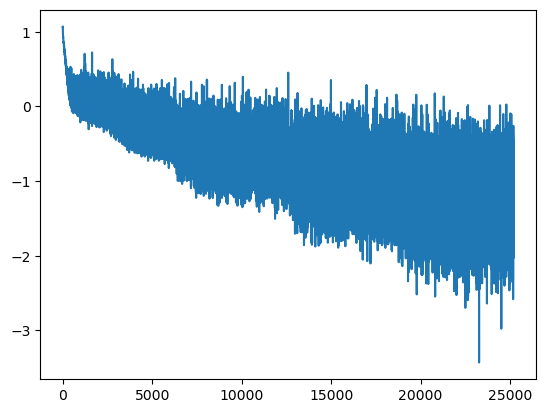

In [341]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.log(1.6+torch.tensor(train_loss)))

In [352]:
#test_dataset = TensorDataset(X_train, train_indices)
test_dataset = TensorDataset(X_test, test_indices)
test_loader = DataLoader(test_dataset, batch_size=256)

# Set into eval mode
model.eval()
likelihood.eval()
yhat = []
yvar = []
print("Predicting at test inputs")
with torch.no_grad(), gpytorch.settings.cholesky_max_tries(12):
    minibatch_iter = tqdm(test_loader,desc="Minibatch", leave=False)
    for x_batch, task_batch in minibatch_iter:
        predictions = (model(x_batch, task_indices=task_batch))
        mean = predictions.mean
        var = predictions.covariance_matrix
        yhat.append(mean)
        yvar.append(var)
        

yhat_vector = torch.cat(yhat, 0)
#yvar_vector = torch.cat(yvar,0)

Predicting at test inputs


Minibatch:   0%|          | 0/2 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [366]:
predictions = (model(X_train[0:100,:], task_indices=train_indices[0:100]))

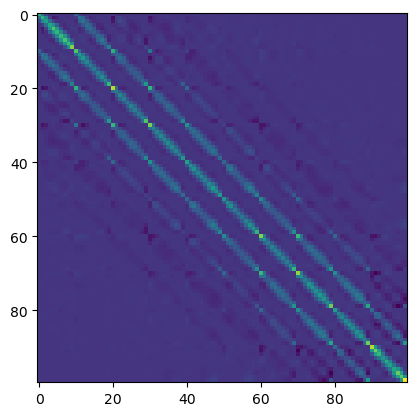

In [368]:
plt.imshow(predictions.covariance_matrix.detach())

In [343]:
yhat_vector

tensor([ 0.9764,  0.9785,  0.9678,  0.9508,  0.9320,  0.9122,  0.8816,  0.8426,
         0.8117,  0.7815,  0.9894,  0.9826,  0.9667,  0.9481,  0.9311,  0.9150,
         0.8862,  0.8472,  0.8167,  0.7834,  0.9909,  0.9812,  0.9636,  0.9451,
         0.9299,  0.9148,  0.8819,  0.8343,  0.7958,  0.7564,  0.9849,  0.9743,
         0.9553,  0.9370,  0.9244,  0.9108,  0.8732,  0.8154,  0.7666,  0.7217,
         0.9816,  0.9705,  0.9490,  0.9304,  0.9205,  0.9090,  0.8700,  0.8084,
         0.7559,  0.7098,  0.9789,  0.9707,  0.9489,  0.9297,  0.9199,  0.9074,
         0.8687,  0.8114,  0.7646,  0.7214,  0.9366,  0.9333,  0.9147,  0.8960,
         0.8841,  0.8697,  0.8358,  0.7911,  0.7564,  0.7182,  0.8276,  0.8258,
         0.8114,  0.7951,  0.7842,  0.7746,  0.7545,  0.7282,  0.7063,  0.6736,
         0.6896,  0.6835,  0.6710,  0.6578,  0.6527,  0.6556,  0.6539,  0.6438,
         0.6301,  0.6040,  0.5799,  0.5642,  0.5485,  0.5367,  0.5385,  0.5533,
         0.5643,  0.5623,  0.5533,  0.53

In [344]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[0.4084]], requires_grad=True)

In [345]:
print("our error: ",(y_train - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_train-torch.tensor(train["p0Mean"].values)).square().mean().sqrt())

RuntimeError: The size of tensor a (2000) must match the size of tensor b (500) at non-singleton dimension 0

In [346]:
print("our error: ",(y_test - yhat_vector).square().mean().sqrt())
print("baseline error: ",(y_test-torch.tensor(test["p0Mean"].values)).square().mean().sqrt())

our error:  tensor(0.0799)
baseline error:  tensor(0.0447, dtype=torch.float64)


our error:  tensor(0.0662, dtype=torch.float64)
baseline error:  tensor(0.0434, dtype=torch.float64)


Text(0.5, 1.0, 'Our Prediction')

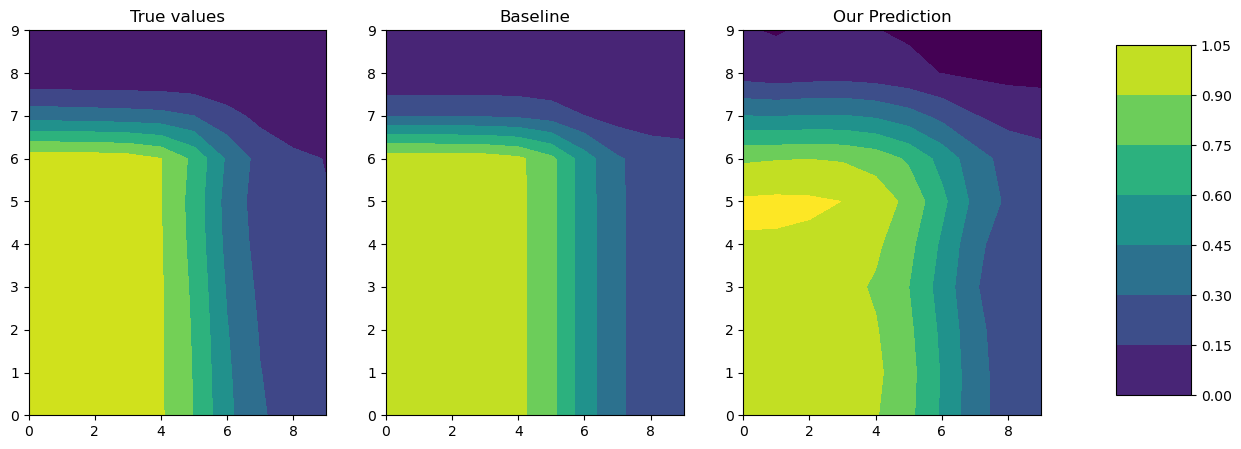

In [347]:
start = 300
end = start + 100

fhat = yhat_vector[start:end].reshape(10,10)
var = yvar_vector[start:end].reshape(10,10)
f = torch.tensor(test.iloc[start:end,7].values).reshape(10,10)
p0 = torch.tensor(test.iloc[start:end,9].values).reshape(10,10)
print("our error: ",(fhat-f).square().mean().sqrt())
print("baseline error: ",(p0-f).square().mean().sqrt())

# Compute shared vmin/vmax
vmin = torch.min(torch.stack([f.min(), p0.min(), fhat.min()])).item()
vmax = torch.max(torch.stack([f.max(), p0.max(), fhat.max()])).item()



fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 5))
im = axes[0].contourf(f, vmin=vmin, vmax=vmax)
axes[0].contourf(f)
axes[1].contourf(p0, vmin=vmin, vmax=vmax)
axes[2].contourf(fhat, vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

axes[0].set_title("True values")
axes[1].set_title("Baseline")
axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'True values')

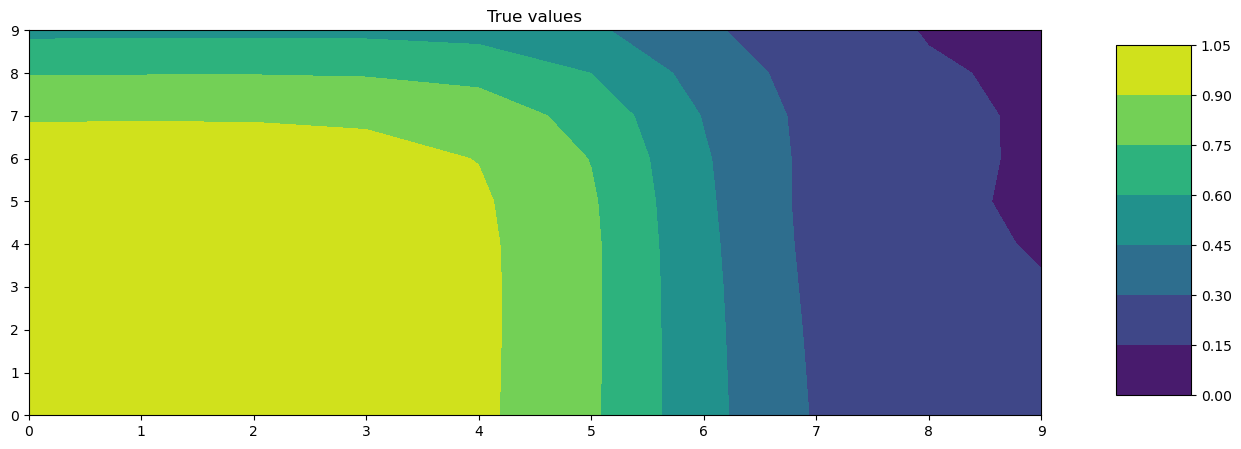

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
axes.contourf(f)
#axes[1].contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(f)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

axes.set_title("True values")
#axes[1].set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Baseline')

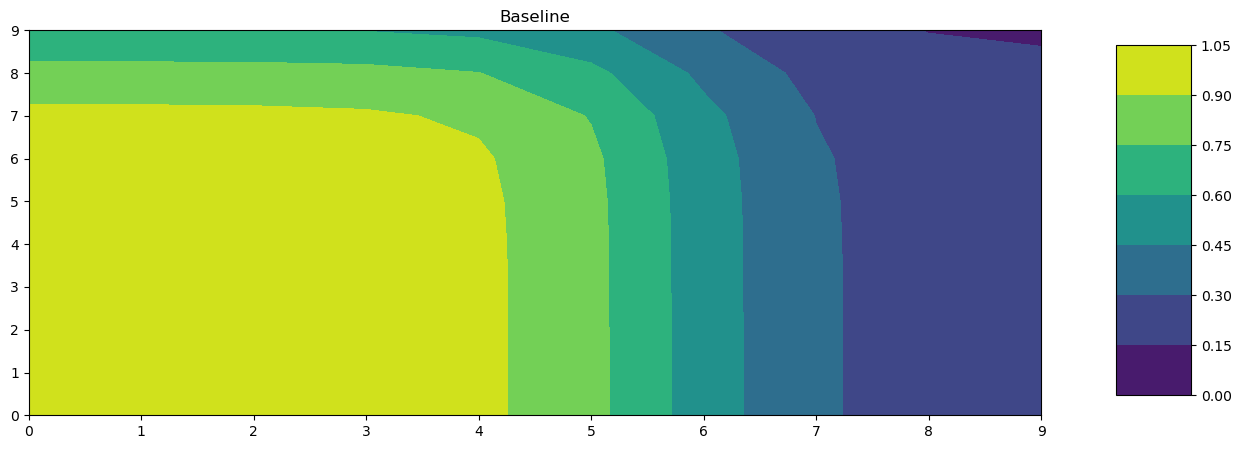

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
axes.contourf(p0)
#axes[2].contourf(fhat)
im = axes.contourf(p0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
axes.set_title("Baseline")
#axes[2].set_title("Our Prediction")

Text(0.5, 1.0, 'Our Prediction')

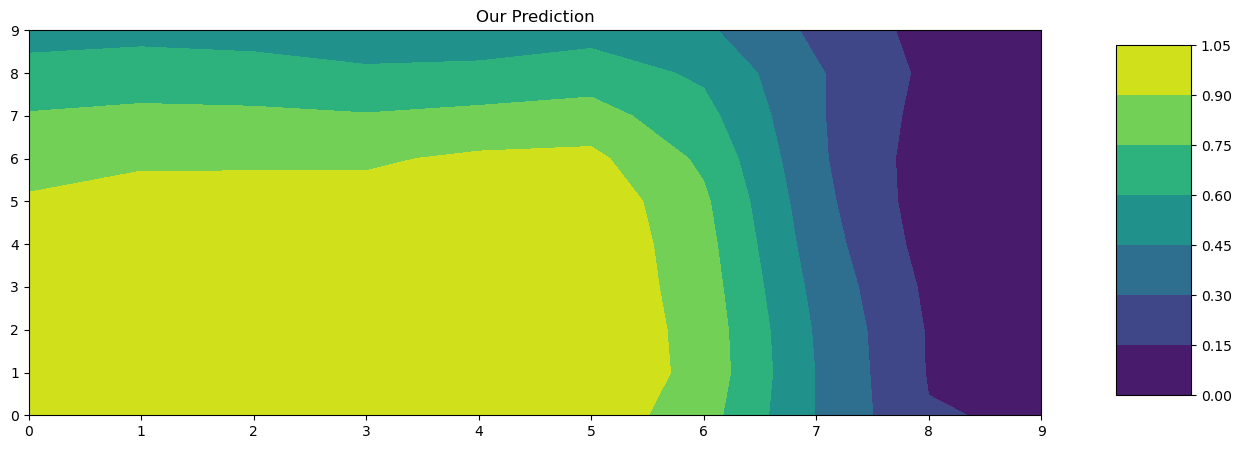

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15, 5))
#axes.contourf(f)
#axes.contourf(p0)
axes.contourf(fhat)
im = axes.contourf(fhat)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax)

#axes.set_title("True values")
#axes.set_title("Baseline")
axes.set_title("Our Prediction")

In [198]:
fhat

tensor([[0.9319, 0.9460, 0.9241, 0.9183, 0.9401, 0.9075, 0.7196, 0.4077, 0.1511,
         0.1032],
        [0.9452, 0.9581, 0.9277, 0.9158, 0.9437, 0.9209, 0.7280, 0.3958, 0.1272,
         0.0931],
        [0.9354, 0.9532, 0.9227, 0.9095, 0.9404, 0.9216, 0.7258, 0.3859, 0.1179,
         0.0980],
        [0.9212, 0.9461, 0.9212, 0.9112, 0.9430, 0.9206, 0.7168, 0.3713, 0.1067,
         0.0968],
        [0.9136, 0.9439, 0.9250, 0.9199, 0.9514, 0.9213, 0.7072, 0.3575, 0.0966,
         0.0913],
        [0.9042, 0.9371, 0.9213, 0.9180, 0.9471, 0.9108, 0.6936, 0.3495, 0.0973,
         0.0930],
        [0.8657, 0.8980, 0.8815, 0.8751, 0.8996, 0.8637, 0.6602, 0.3403, 0.1067,
         0.1019],
        [0.7794, 0.8063, 0.7865, 0.7749, 0.7956, 0.7695, 0.5977, 0.3203, 0.1143,
         0.1075],
        [0.6615, 0.6785, 0.6559, 0.6418, 0.6614, 0.6498, 0.5177, 0.2908, 0.1156,
         0.1049],
        [0.5511, 0.5572, 0.5353, 0.5232, 0.5424, 0.5408, 0.4427, 0.2631, 0.1181,
         0.1041]])

In [229]:
p0

tensor([[1.0000, 1.0000, 1.0000, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9999, 0.9999, 0.9999, 0.9998, 0.9982, 0.9799, 0.7896, 0.2170, 0.0456,
         0.0301],
        [0.9998, 0.9998, 0.9998, 0.9997, 0.9981, 0.9798, 0.7895, 0.2170, 0.0456,
         0.0301],
        [0.9994, 0.9994, 0.9994, 0.9993, 0.9977, 0.9794, 0.7892, 0.2169, 0.0456,
         0.0300],
        [0.9983, 0.9983, 0.9983, 0.9981, 0.9965, 0.9783, 0.7883, 0.2167, 0.0455,
         0.0300],
        [0.9944, 0.9944, 0.9944, 0.9943, 0.9927, 0.9745, 0.7852, 0.2158, 0.0453,
         0.0299],
        [0.9812, 0.9812, 0.9812, 0.9811, 0.9795, 0.9616, 0.7748, 0.2130, 0.0447,
         0.0295],
        [0.9356, 0.9356, 0.9356, 0.9355, 0.9340, 0.9169, 0.7388, 0.2031, 0.0427,
         0.0281],
        [0.8028, 0.8028, 0.8028, 0.8027, 0.8014, 0.7868, 0.6340, 0.1743, 0.0366,
         0.0241],
        [0.6052, 0.6052, 0.6052, 0.6051, 0.6041, 0.5931, 0.4779, 0.1314, 0.0276,
         0.0182]], dtype=tor

In [217]:
(fhat-f).abs()

tensor([[0.0128, 0.0061, 0.0066, 0.0039, 0.0057, 0.0113, 0.0154, 0.0142, 0.0064,
         0.0079],
        [0.0079, 0.0073, 0.0083, 0.0072, 0.0077, 0.0076, 0.0054, 0.0018, 0.0024,
         0.0081],
        [0.0210, 0.0178, 0.0248, 0.0301, 0.0319, 0.0328, 0.0324, 0.0290, 0.0230,
         0.0172],
        [0.0004, 0.0009, 0.0122, 0.0198, 0.0210, 0.0177, 0.0109, 0.0008, 0.0088,
         0.0130],
        [0.0405, 0.0492, 0.0448, 0.0423, 0.0456, 0.0528, 0.0614, 0.0678, 0.0662,
         0.0520],
        [0.0042, 0.0271, 0.0362, 0.0433, 0.0511, 0.0568, 0.0573, 0.0493, 0.0287,
         0.0056],
        [0.1898, 0.1673, 0.1520, 0.1392, 0.1316, 0.1335, 0.1452, 0.1660, 0.1942,
         0.2263],
        [0.0295, 0.0430, 0.0287, 0.0260, 0.0222, 0.0281, 0.0148, 0.0764, 0.0778,
         0.1132],
        [0.1015, 0.0863, 0.0910, 0.1020, 0.1038, 0.0900, 0.0676, 0.0488, 0.0441,
         0.0583],
        [0.0653, 0.0810, 0.0713, 0.0560, 0.0523, 0.0633, 0.0783, 0.0835, 0.0706,
         0.0370]], dtype=tor

Text(0.5, 1.0, 'Predictive variance')

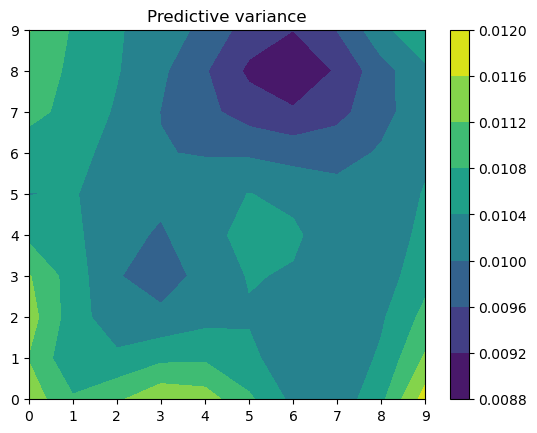

In [29]:
plt.contourf(var)
plt.colorbar()
plt.title("Predictive variance")